# notMNIST sample for TensorFlow

From: http://enakai00.hatenablog.com/entry/2016/08/02/102917

## Dowloading notMNIST images

In [ ]:
!curl -OL http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
!tar -xzf notMNIST_small.tar.gz

## Defining notMNIST class

In [1]:
import numpy as np
from PIL import Image
import os

class NotMNIST:
    def __init__(self):
        train_images, test_images = [], []
        train_labels, test_labels = [], []

        for i, letter in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
            directory = 'notMNIST_small/%s/' % letter
            files = os.listdir(directory)
            images = []
            for file in files:
                try:
                    im = Image.open(directory+file)
                except:
                    print "Skip a corrupted file: " + file
                    continue
                pixels = np.array(im.convert('L').getdata())
                images.append(pixels)
                
            num_testset = len(images) / 6
            label = np.array([0]*10)
            label[i] = 1
            new_test_images = [np.array(x) for x in images[:num_testset]]
            new_train_images = [np.array(x) for x in images[num_testset:]]
            test_images.extend(new_test_images)
            train_images.extend(new_train_images)
            test_labels.extend([label] * len(new_test_images))
            train_labels.extend([label] * len(new_train_images))
        
        train_zipped = zip(train_images, train_labels)
        test_zipped = zip(test_images, test_labels)
        np.random.shuffle(train_zipped)
        np.random.shuffle(test_zipped)
        
        class train:
            def __init__(self):
                self.images = []
                self.labels = []
                self.batch_counter = 0
                
            def next_batch(self, num):
                if self.batch_counter + num >= len(self.labels):
                    batch_images = self.images[self.batch_counter:]
                    batch_labels = self.labels[self.batch_counter:]
                    left = num - len(batch_labels)
                    batch_images.extend(self.images[:left])
                    batch_labels.extend(self.labels[:left])
                    self.batch_counter = left
                else:
                    batch_images = self.images[self.batch_counter:self.batch_counter+num]
                    batch_labels = self.labels[self.batch_counter:self.batch_counter+num]                  
                    self.batch_counter += num
                    
                return (batch_images, batch_labels)
                    
        class test:
            def __init__(self):
                self.images = []
                self.labels = []
                
        self.train = train()
        self.test = test()
                
        self.train.images = [x/255.0 for (x,y) in train_zipped]
        self.train.labels = [y for (x,y) in train_zipped]
        self.test.images = [x/255.0 for (x,y) in test_zipped]
        self.test.labels = [y for (x,y) in test_zipped]

## Loading the notMNIST images

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
mnist = NotMNIST()

Skip a corrupted file: RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Skip a corrupted file: Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


## Displaying the notMNIST images

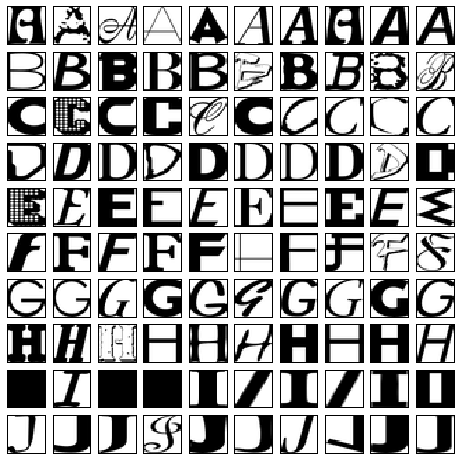

In [3]:
fig = plt.figure(figsize=(8,8))
for i in range(10):
    c = 0
    for (image, label) in zip(mnist.test.images, mnist.test.labels):
        if np.argmax(label) != i: continue
        subplot = fig.add_subplot(10,10,i*10+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        c += 1
        if c == 10: break

## Training with the single-layer MNIST sample
From: https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html

In [4]:
import tensorflow as tf

sess = tf.InteractiveSession()

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Train
tf.initialize_all_variables().run()
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  train_step.run({x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

0.1


## Training with the CNN MNIST sample

From: https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# the first layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# the second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# fully-connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# softmax layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# train step
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# train and evaluate
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.08
step 100, training accuracy 0.94
step 200, training accuracy 0.86
step 300, training accuracy 0.88
step 400, training accuracy 0.88
step 500, training accuracy 0.94
step 600, training accuracy 0.88
step 700, training accuracy 0.9
step 800, training accuracy 0.98
step 900, training accuracy 0.9
step 1000, training accuracy 0.92
step 1100, training accuracy 0.86
step 1200, training accuracy 0.98
step 1300, training accuracy 0.88
step 1400, training accuracy 0.86
step 1500, training accuracy 0.88
step 1600, training accuracy 0.94
step 1700, training accuracy 0.94
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 0.88
step 2100, training accuracy 0.96
step 2200, training accuracy 0.94
step 2300, training accuracy 0.96
step 2400, training accuracy 0.96
step 2500, training accuracy 1
step 2600, training accuracy 0.94
